## Scenario Descriptions

### CAGE Challenge 2

Subnet 1 consists of user hosts that are not critical. \
Subnet 2 consists of enterprise servers designed to support the user activities on Subnet 1. \
Subnet 3 contains the critical operational server and three user hosts.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure1.png">

The effect of each action on the state of a targeted host is summarized with the diagram.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure2.png" caption="State Diagram">

### Agents

- Rules-based agents
- Deep Reinforcement Learning agents

In [1]:
import subprocess
import inspect
import time
import os
from statistics import mean, stdev
import random
import collections
from pprint import pprint

import matplotlib.pyplot as plt
import networkx as nx
from networkx import connected_components
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from CybORG import CybORG, CYBORG_VERSION

from CybORG.Agents import B_lineAgent, BlueReactRestoreAgent, BlueReactRemoveAgent, \
    RandomAgent, RedMeanderAgent, SleepAgent
from CybORG.Agents.MainAgent import MainAgent

from CybORG.Agents.Wrappers.ChallengeWrapper import ChallengeWrapper
from CybORG.Agents.Wrappers.ChallengeWrapper2 import ChallengeWrapper2
from CybORG.Agents.Wrappers import EnumActionWrapper
from CybORG.Agents.Wrappers.FixedFlatWrapper import FixedFlatWrapper
from CybORG.Agents.Wrappers.IntListToAction import IntListToActionWrapper
from CybORG.Agents.Wrappers.OpenAIGymWrapper import OpenAIGymWrapper
from CybORG.Simulator.Scenarios.FileReaderScenarioGenerator import FileReaderScenarioGenerator

from CybORG.Visualizers.GameStateManager import GameStateManager 

from CybORG.Visualizers.NetworkVisualizer import NetworkVisualizer
# from CybORG.Tutorial.Visualizers import NetworkVisualizer

/home/lab_linux/anaconda3/envs/cyborg_visual/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


path is: /home/lab_linux/harsh/CAGE_RL/vu_emu/visualizer/CybORG-main/CybORG/env.py


## Visualization

- input 
    - Observation from Red and Blue
    - Action for Blue / Red?
    - link_diagram

Mouse over event oberservations 
Different Shape
Different State

In [2]:
MAX_EPS = 1
agent_name = 'Blue'
random.seed(0)
cyborg_version = CYBORG_VERSION
scenario = 'Scenario2'

def wrap(env):
    # return ChallengeWrapper2(env=env, agent_name='Blue')
    return ChallengeWrapper(env=env, agent_name='Blue')

##### The main function below runs the game and also run the game data collection for visualization, and finally return captured data for visualization in a large dictionary format. 

##### Please see the comment in the code to understand how to use the game visualizer in your own code. 

In [3]:
def main():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario2'
    # commit_hash = get_git_revision_hash()
    commit_hash = "Not using git"
    # ask for a name
    name = "John Hannay"
    # ask for a team
    team = "CardiffUni"
    # ask for a name for the agent
    name_of_agent = "PPO + Greedy decoys"

    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = MainAgent()
    
    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')
    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'
    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # Initialization of game state manager
    game_state_manager = GameStateManager()
    #######################################
    
    for num_steps in [10]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, 'sim', agents={'Red': red_agent})
            wrapped_cyborg = wrap(cyborg)

            observation = wrapped_cyborg.reset()
           

            ############### Set up environment for game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent=red_agent,
                                               blue_agent=agent,
                                               num_steps=num_steps)
            ########################################################
            
            action_space = wrapped_cyborg.get_action_space(agent_name)
            total_reward = []
            actions = []
            for i in range(MAX_EPS):
                r = []
                a = []
            
                for j in range(num_steps):
                    action = agent.get_action(observation, action_space)
                    observation, rew, done, info = wrapped_cyborg.step(action)
                    r.append(rew)
                    a.append((str(cyborg.get_last_action('Blue')), str(cyborg.get_last_action('Red'))))

                    
                    ################ create game info state for each step and store the information 
                    state_snapshot = game_state_manager.create_state_snapshot()
                    game_state_manager.store_state(state_snapshot, i, j)
                    ######################################################
                
                
                agent.end_episode()
                total_reward.append(sum(r))
                actions.append(a)
                observation = wrapped_cyborg.reset()

                # game manager reset
                game_state_manager.reset()
    #return the information dictionary for plotting
    return game_state_manager.get_game_state()

In [4]:
%%capture
game_state = main()

In [5]:
#pprint(game_state)

##### The data generated duting game is  passed to Network visualizer, that plot and save the images. 
##### These are interactive plotly plots, so mouseover can give some more information. After saving the plot to local disc, the static image with not be interactive. 

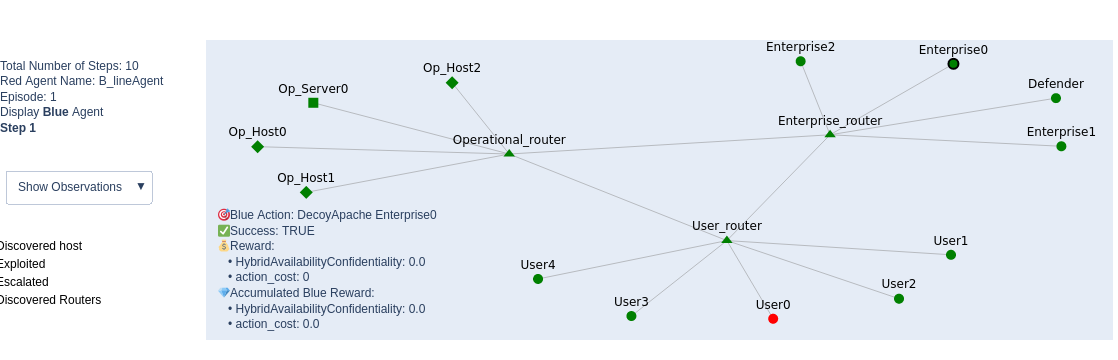

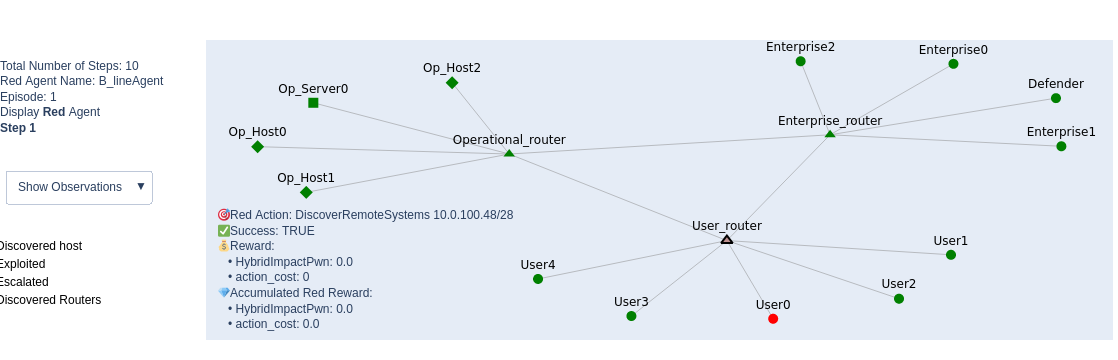

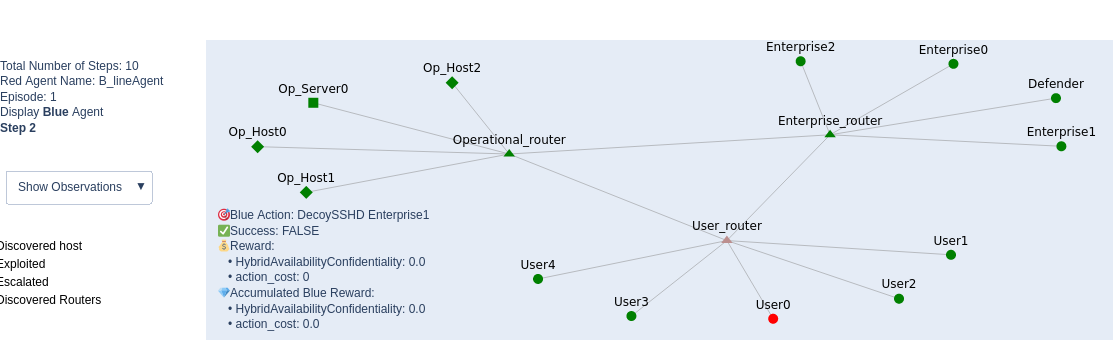

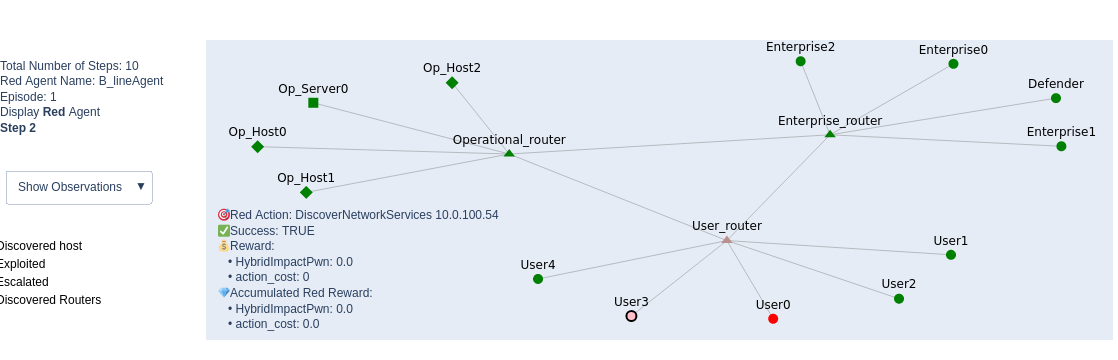

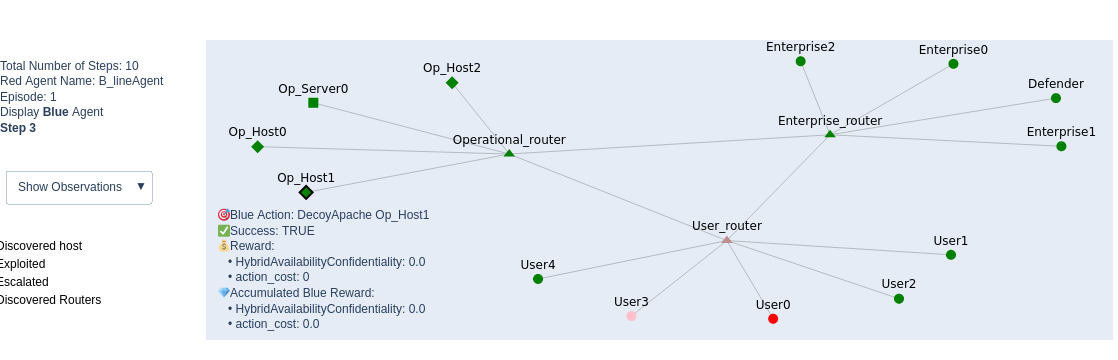

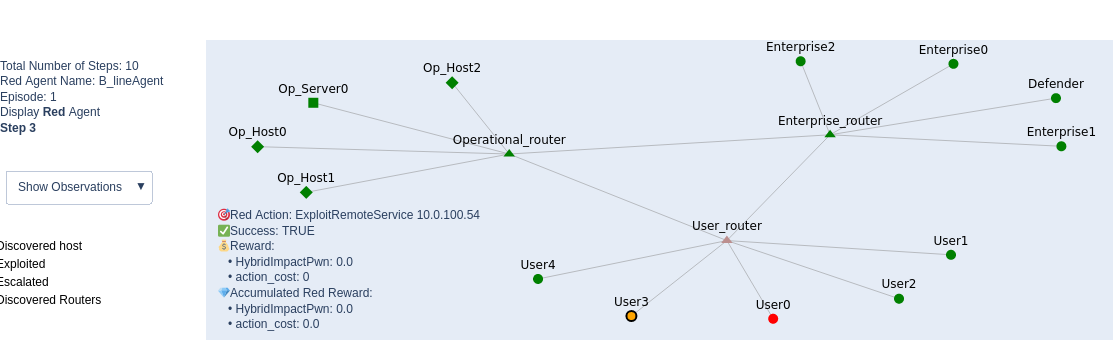

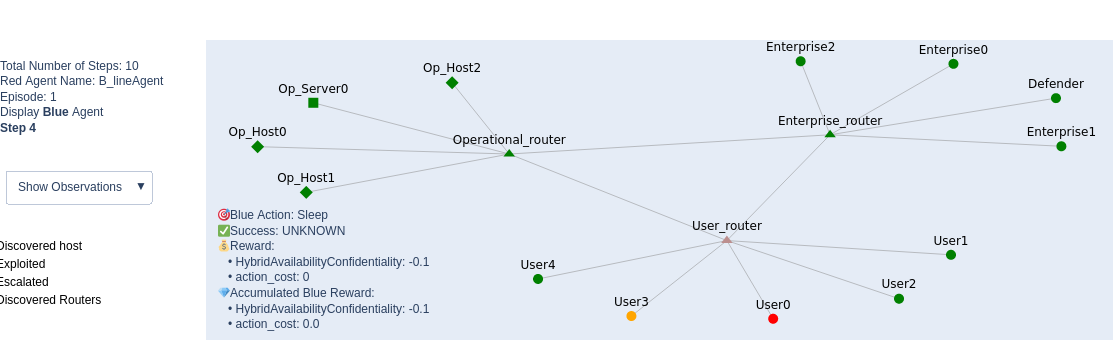

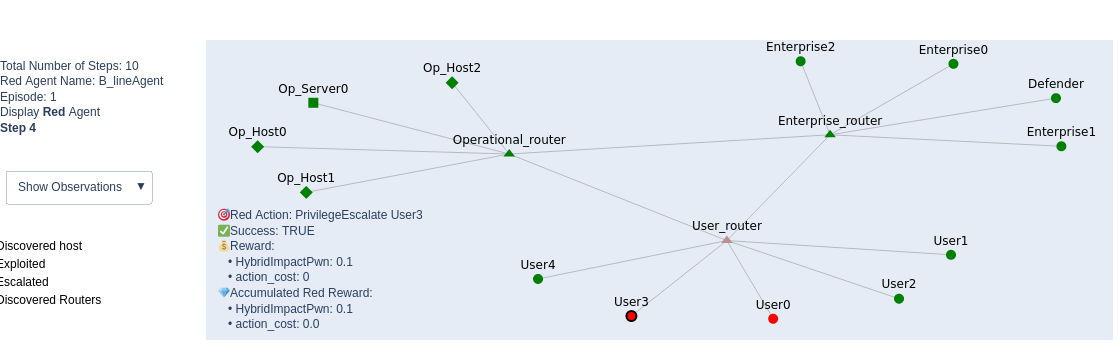

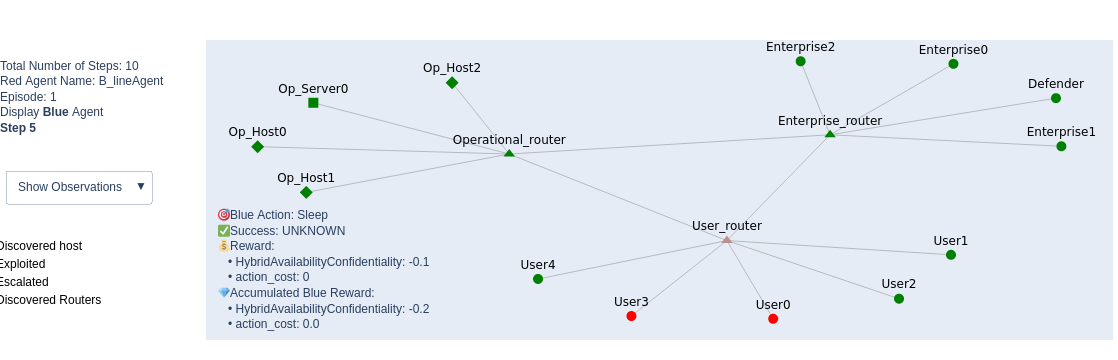

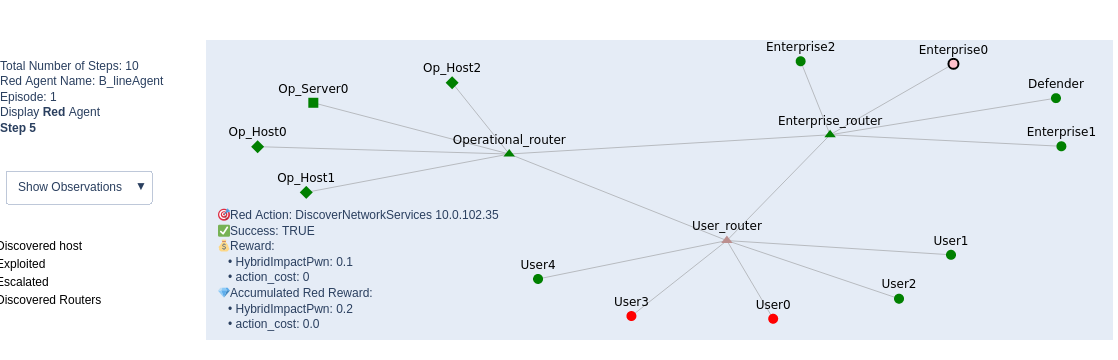

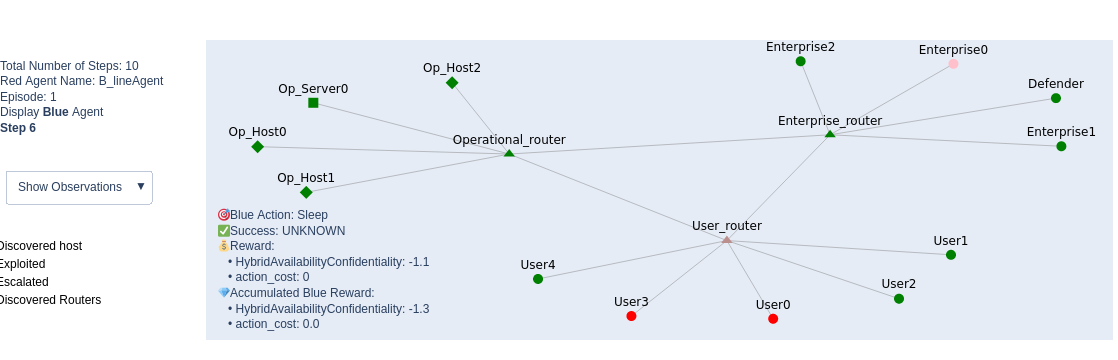

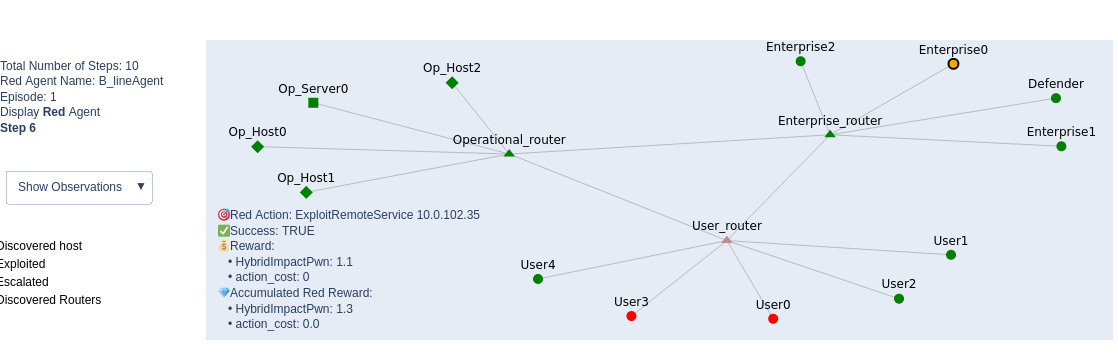

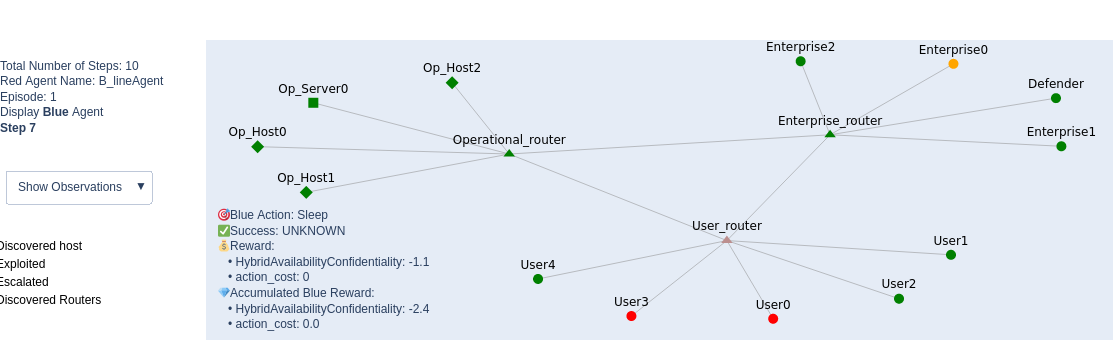

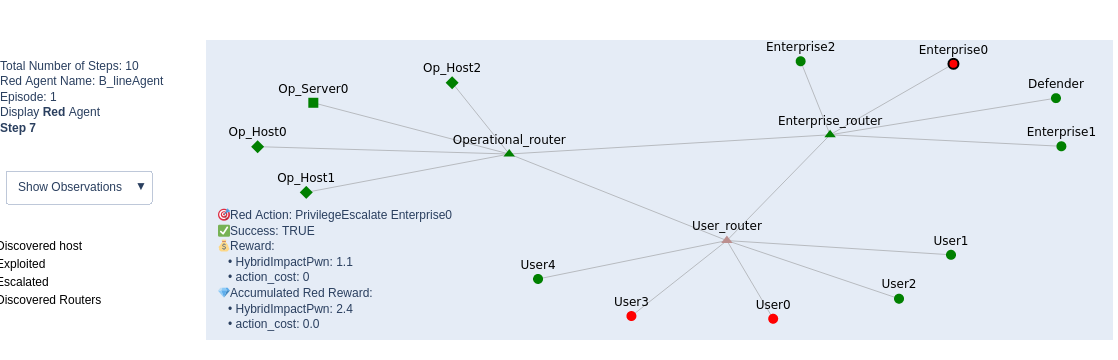

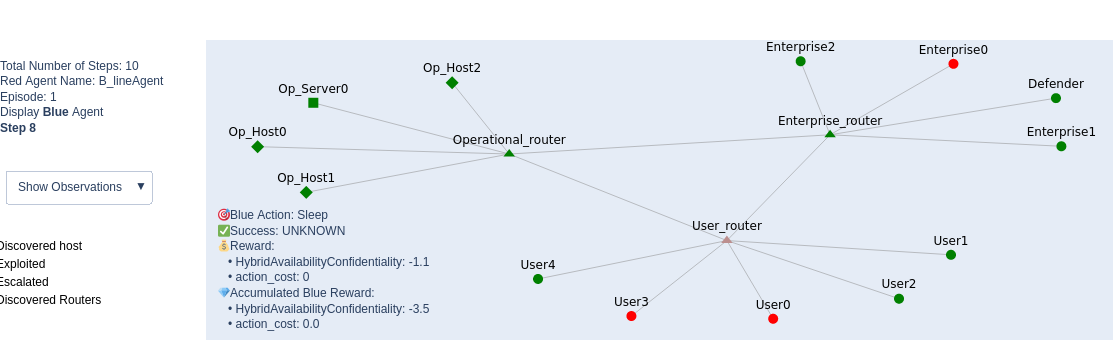

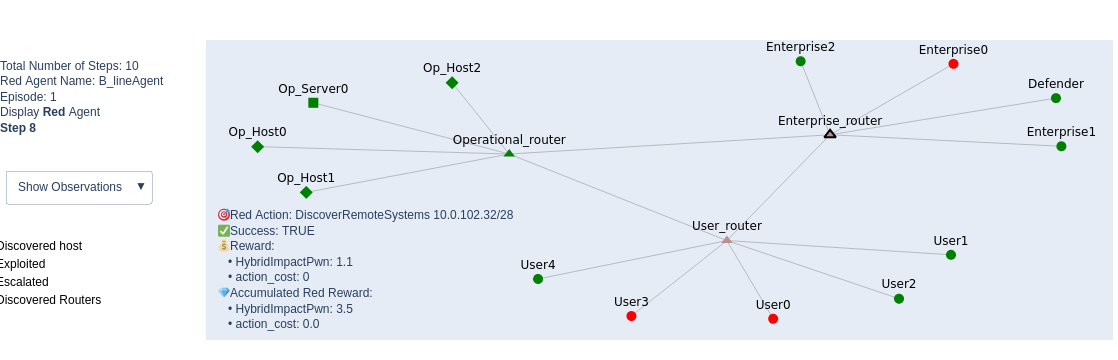

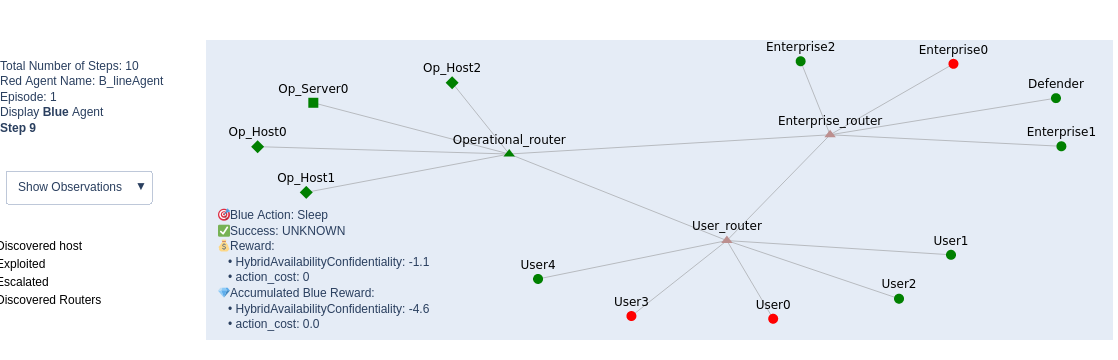

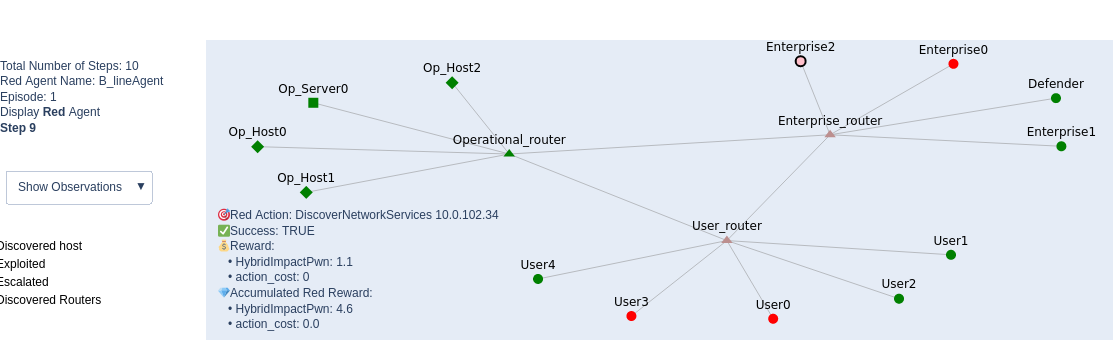

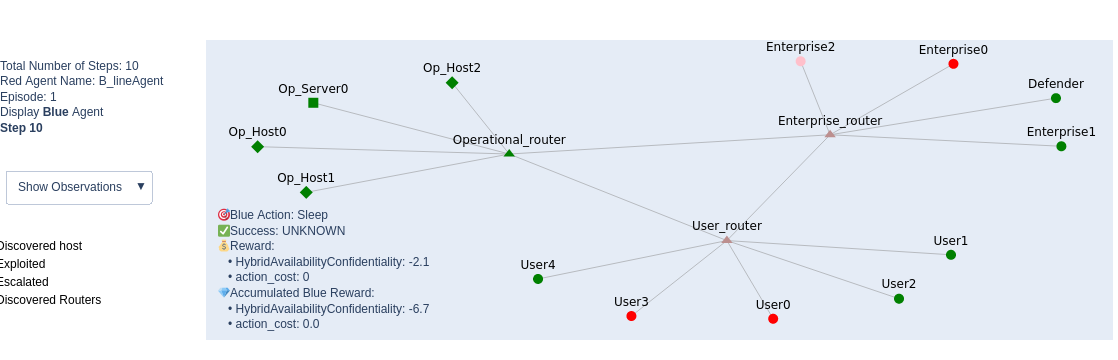

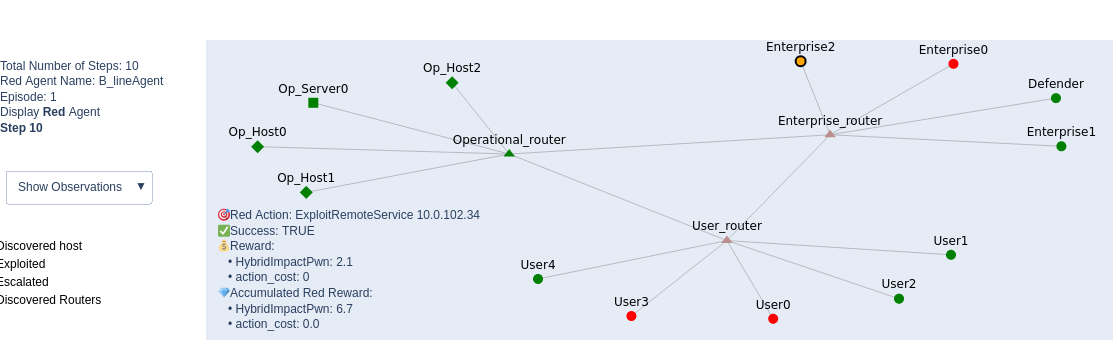

In [6]:
nv = NetworkVisualizer(game_state)
nv.plot(save=False)

## with differnt network

In [7]:
def main_simple_agent():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario_5nodes_randomgame'


    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = BlueReactRemoveAgent()
    
    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')


    path = str(inspect.getfile(CybORG))
    #path = path[:-10] + f'/Shared/Scenarios/{scenario}.yaml'
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/{scenario}.yaml'
    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # game manager initialization
    game_state_manager = GameStateManager()
    
    for num_steps in [10]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, 'sim', agents={'Red': red_agent})

            observation = cyborg.reset()
            # observation = cyborg.reset().observation

            # set up game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent=red_agent,
                                               blue_agent=agent,
                                               num_steps=num_steps)
            game_state_manager.reset()

            
            action_space = cyborg.get_action_space(agent_name)
            # action_space = cyborg.get_action_space(agent_name)
            total_reward = []
            actions = []
            for i in range(MAX_EPS):
                r = []
                a = []
                
                # cyborg.env.env.tracker.render()
                for j in range(num_steps):
                    blue_action_space = cyborg.get_action_space('Blue')
                    blue_obs = cyborg.get_observation('Blue') # get the newest observation
                    blue_action = agent.get_action(blue_obs, blue_action_space)
                                        
                    result = cyborg.step('Blue', blue_action, skip_valid_action_check=False)
                    
                    state_snapshot = game_state_manager.create_state_snapshot()
                    game_state_manager.store_state(state_snapshot, i, j)

                
                # game manager reset
                agent.end_episode()
                total_reward.append(sum(r))
                actions.append(a)
                # observation = cyborg.reset().observation
                observation = cyborg.reset()
                game_state_manager.reset()
    return game_state_manager.get_game_state()

In [8]:
%%capture
game_state= main_simple_agent()

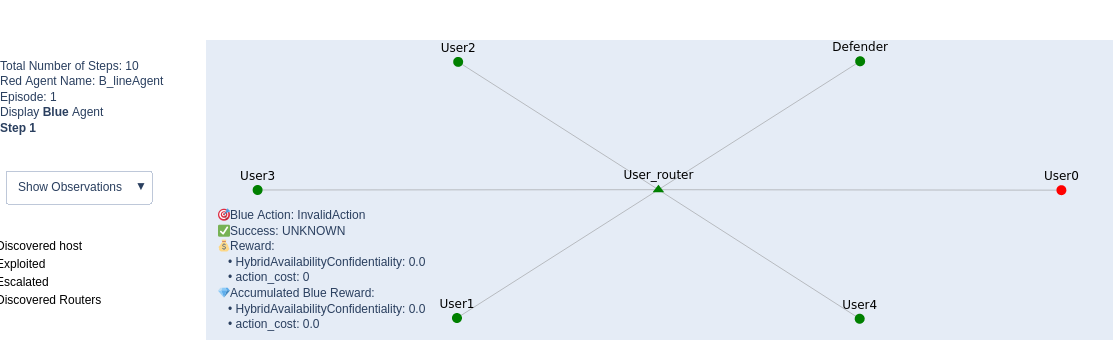

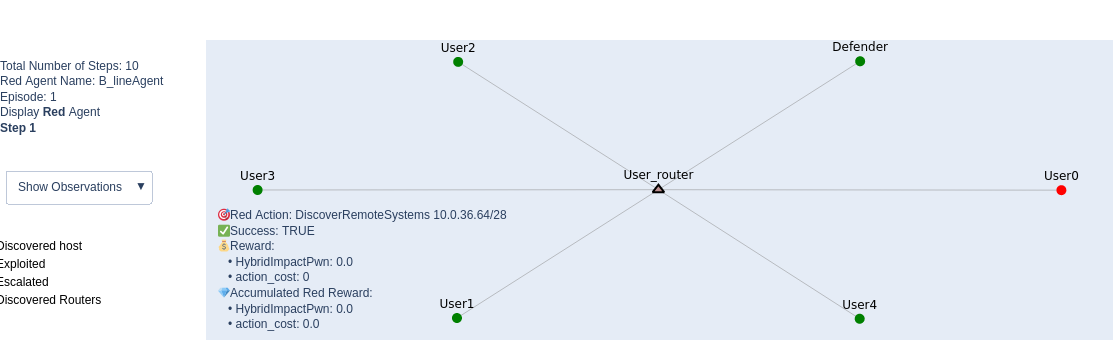

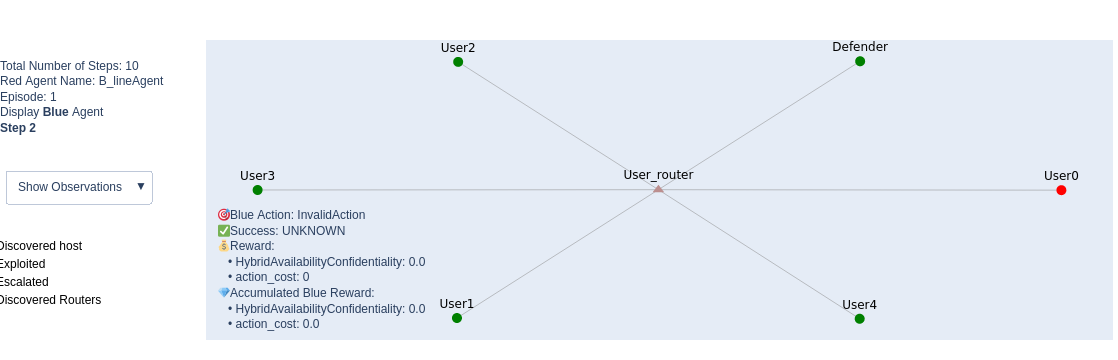

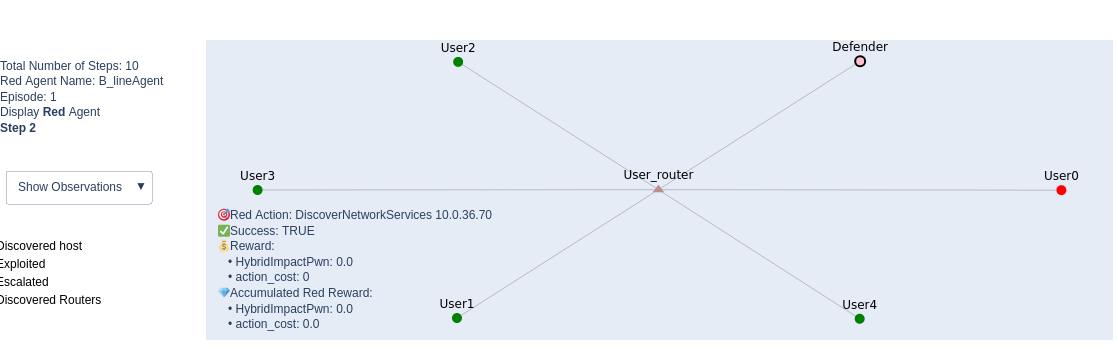

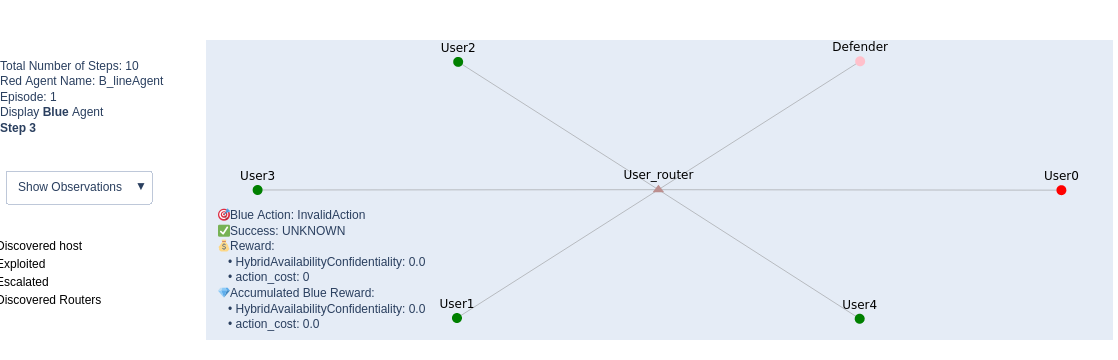

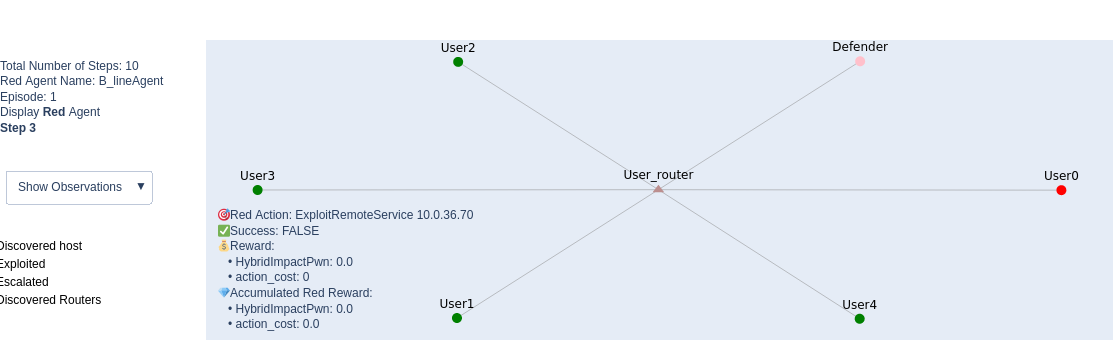

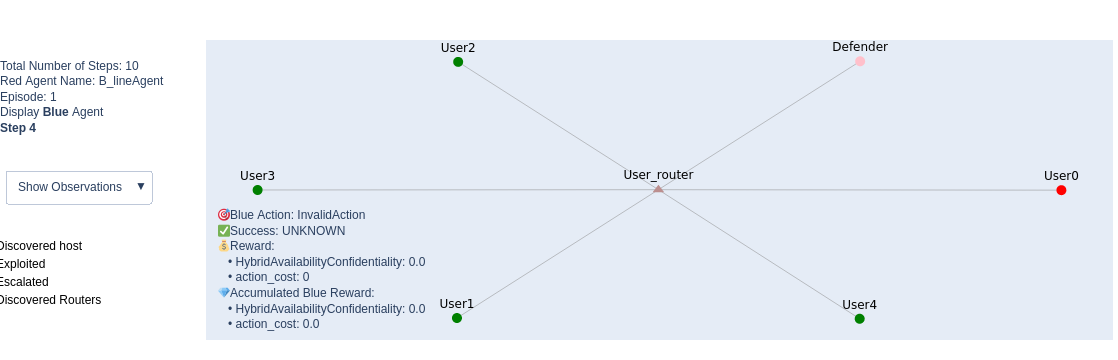

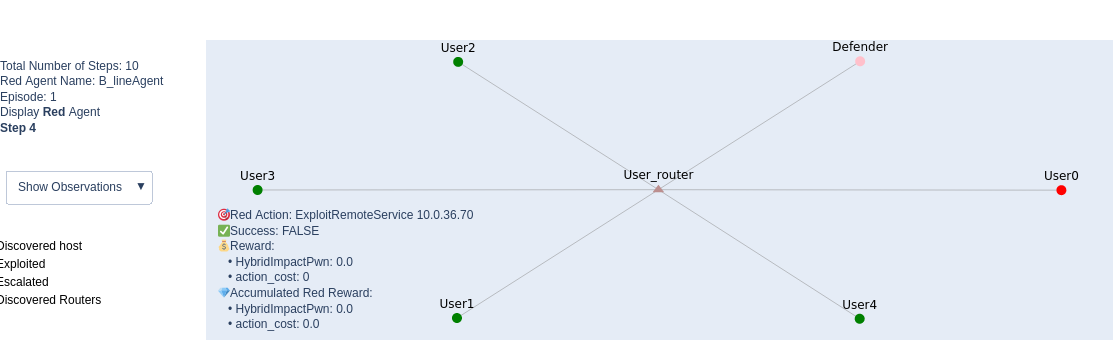

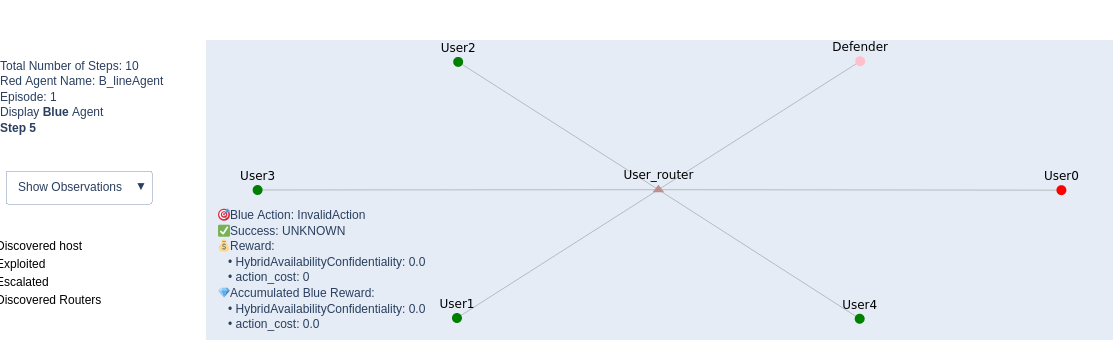

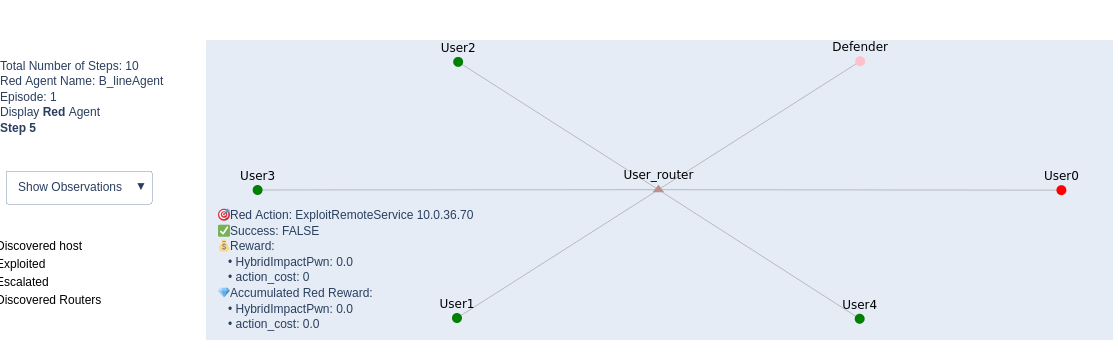

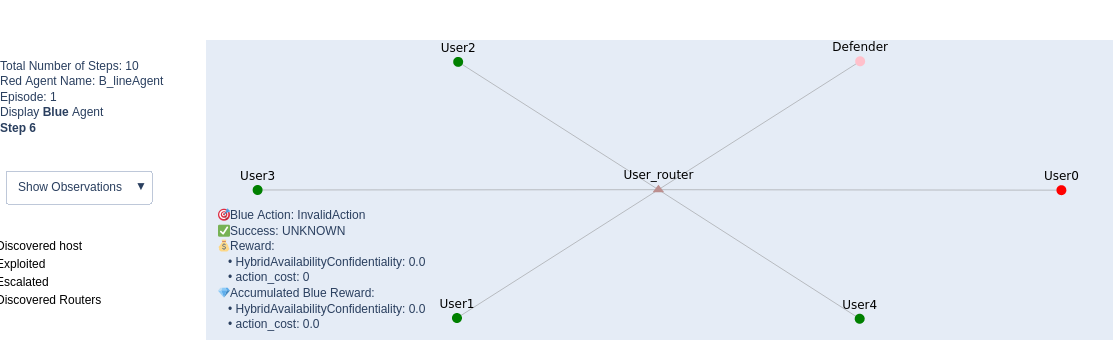

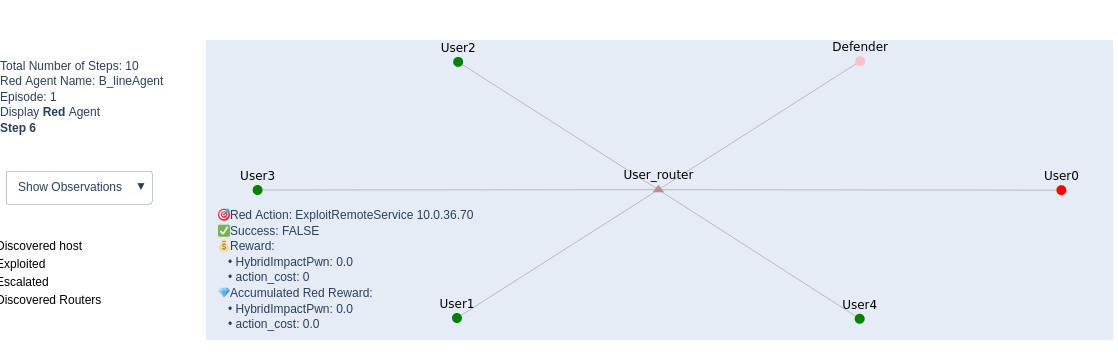

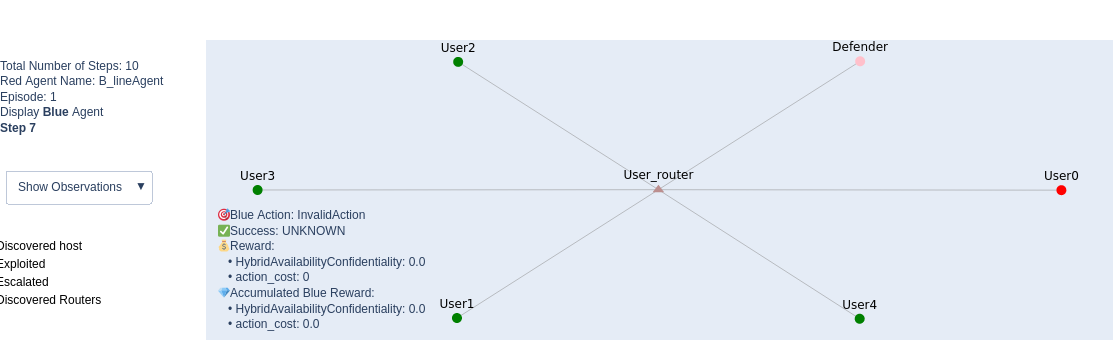

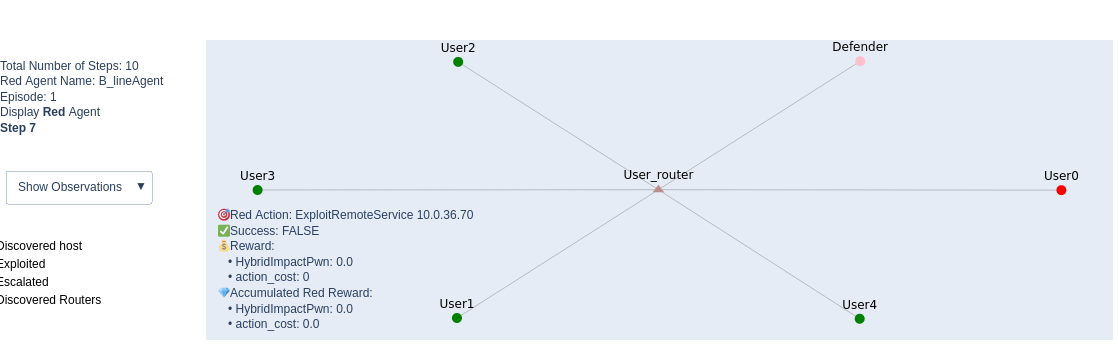

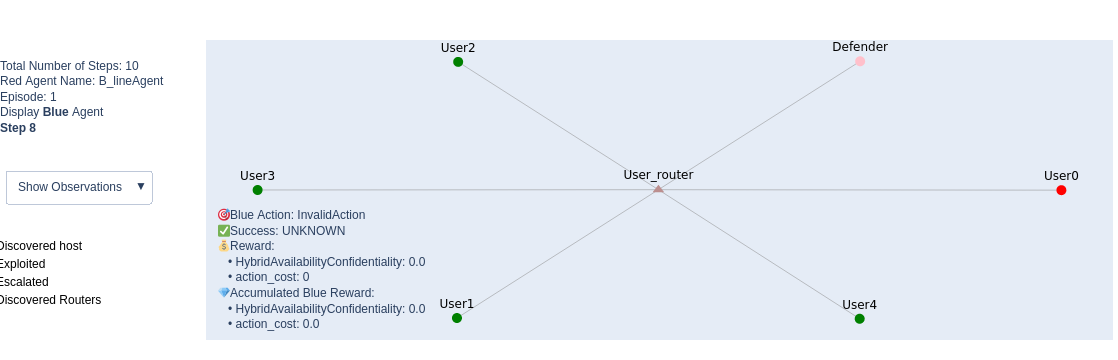

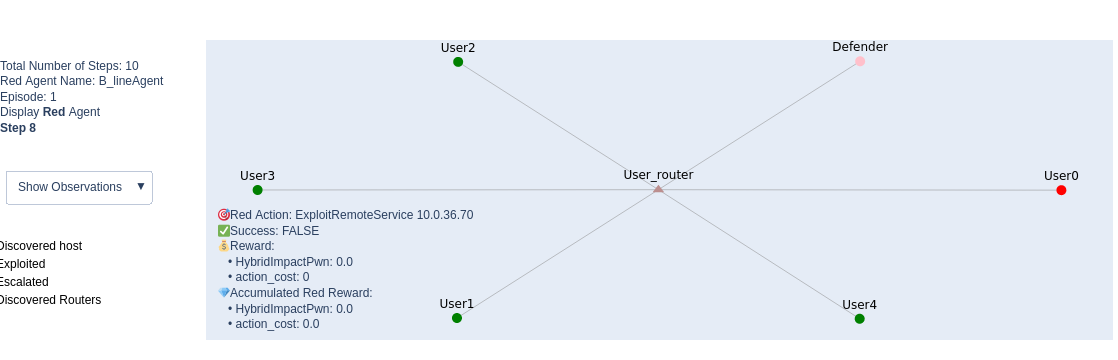

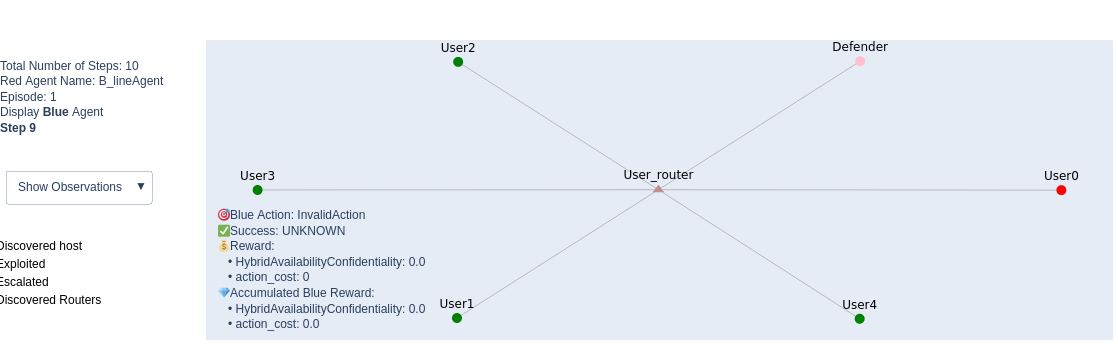

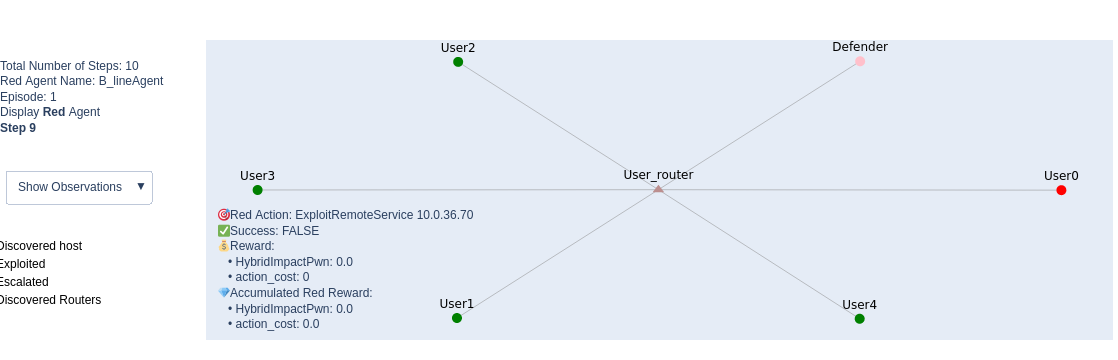

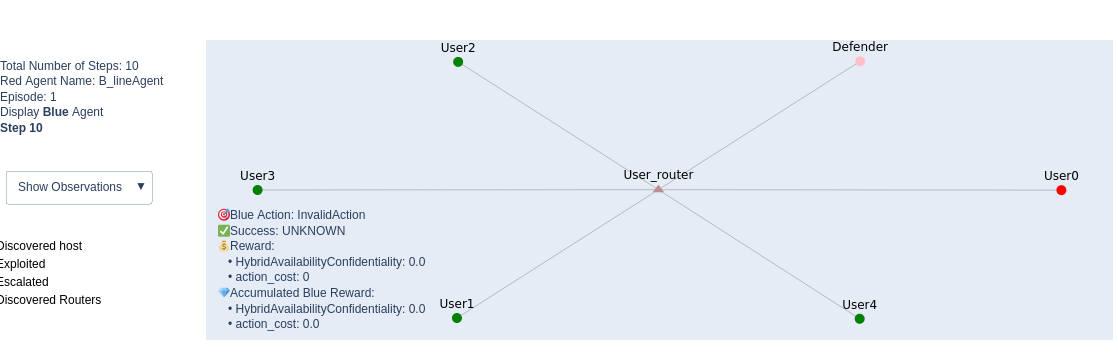

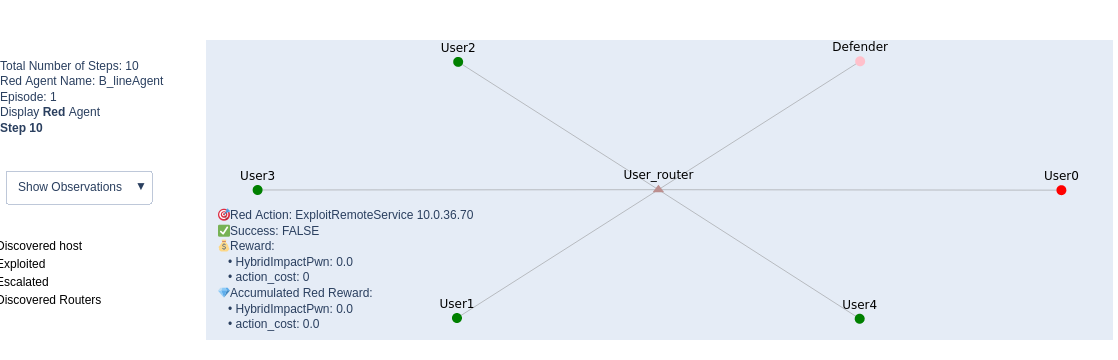

In [9]:
nv=NetworkVisualizer(game_state)
nv.plot(save=False)